## MIAs filtering

This section attempts to filter the resulting ChEMBL NP library to account only for monoterpene indole alkaloids (MIAs).

In [1]:
import pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Lipinski import HeavyAtomCount
from rdkit.Chem.Scaffolds import MurckoScaffold

from tqdm import tqdm

In [2]:
import os
import sys

BASE_PATH = os.path.dirname(os.getcwd())
sys.path.append(BASE_PATH)

from src.utils import count_nitrogen_atoms

The reference MIAs were obtained from table 1 in [Pan et al. 2016](https://link.springer.com/article/10.1007/s11101-015-9406-4) and supplemented with some additional entries from other papers, including figure 1 in an old version of [biorXiv](https://www.biorxiv.org/content/10.1101/2021.08.12.456143v1.full.pdf) and [wikipedia](https://en.wikipedia.org/wiki/Indole_alkaloid?utm_source=chatgpt.com). All the structures were manually searched in PubChem using the common name appearing in the file.

In [3]:
HERE = Path.cwd().parent

chembl = pd.read_csv(HERE / "data" / "processed" / "chembl_35_NP_cleaned.csv")
print(chembl.head(2))
refs = pd.read_csv(HERE / "data" / "raw" / "mia_references.csv")
print(refs.head(2))

      chembl_id                                  taut_smiles
0    CHEMBL1000  O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1
1  CHEMBL100014                     CCCC(=O)OCOC(=O)C(C)(C)C
            Name                                             SMILES
0     Ajmalicine  C[C@H]1[C@H]2CN3CCC4=C([C@@H]3C[C@@H]2C(=CO1)C...
1  Camptothecine  CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=...


In [4]:
scaffolds_smiles = set()
rings = []
for smi in refs["SMILES"]:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    Chem.RemoveStereochemistry(mol)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    if HeavyAtomCount(scaffold) < 16:
        continue
    scaffold_smi = Chem.MolToSmiles(scaffold)
    if scaffold_smi not in scaffolds_smiles:
        scaffolds_smiles.add(scaffold_smi)
    sssr = Chem.GetSSSR(scaffold)
    if len(sssr) > 2:
        rings.append(len(sssr))

In [5]:
min(rings)

4

In [6]:
queries = {
    "tryptamine": "C1=CC=C2C(=C1)C(=CN2)CCN",
    "indoline-ethanamine": "C1C(C2=CC=CC=C2N1)CCN",
    "indoline-propanamine": "C1=CC=C2C(=C1)C(=CN2)CCCN",
    "indolenine": "C2=Nc1ccccc1C2"
}

In [7]:
def contain_min_scaffold(mol):
    if any(mol.HasSubstructMatch(Chem.MolFromSmiles(query)) for query in queries.values()):
        return True
    return False

In [8]:
def comply_restrictions(mol):
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    n_heavy_atoms = HeavyAtomCount(scaffold)
    sssr = Chem.GetSSSR(mol)
    if n_heavy_atoms < 16 or n_heavy_atoms > 28:
        return False
    if count_nitrogen_atoms(scaffold) != 2:
        return False
    if len(sssr) <= 3:
        return False
    return True


In [10]:
indoles_in_chembl = []
mias_in_chembl = []
for i, row in tqdm(chembl.iterrows(), total=len(chembl)):
    mol = Chem.MolFromSmiles(row["taut_smiles"])
    if contain_min_scaffold(mol):
        indoles_in_chembl.append(i)
        if comply_restrictions(mol):
            mias_in_chembl.append(i)

print(len(indoles_in_chembl), len(mias_in_chembl))

100%|██████████| 78163/78163 [00:49<00:00, 1582.25it/s]

3523 1049


In [11]:
fragments = {
    "indole": "c2ccc1[nH]ccc1c2",
    "indolenine": "C2=Nc1ccccc1C2",
    "indoline": "c2ccc1NCCc1c2",
    "oxindole": "O=C2Cc1ccccc1N2"
}

In [12]:
for fr, sm in fragments.items():
    c = 0
    for i in mias_in_chembl:
        m = Chem.MolFromSmiles(chembl["taut_smiles"][i])
        if m.HasSubstructMatch(Chem.MolFromSmiles(sm)):
            c += 1
    print(fr,":", c)

indole : 671
indolenine : 107
indoline : 292
oxindole : 117


In [13]:
chembl.iloc[mias_in_chembl]["chembl_id"].to_csv(HERE / "data" / "MIAs.csv",
                                                index=False)

In [45]:
from rdkit.Chem import BRICS

frags = [BRICS.BRICSDecompose(mol, minFragmentSize=4, returnMols=True) for mol in refs["ROMol"]]
frags = [list(x) for x in frags]

In [46]:
for f in frags:
    print(len(f))

1
1
1
2
4
4
3
3
1
1
1
3
1
2
1
2
1
1
5
3
1
1
1
2
1
1
1
1
2
1
1
2
1


In [47]:
def get_largest(frags):
    n_atoms = []
    for f in frags:
        n_atoms.append(f.GetNumHeavyAtoms())
    return n_atoms.index(max(n_atoms))

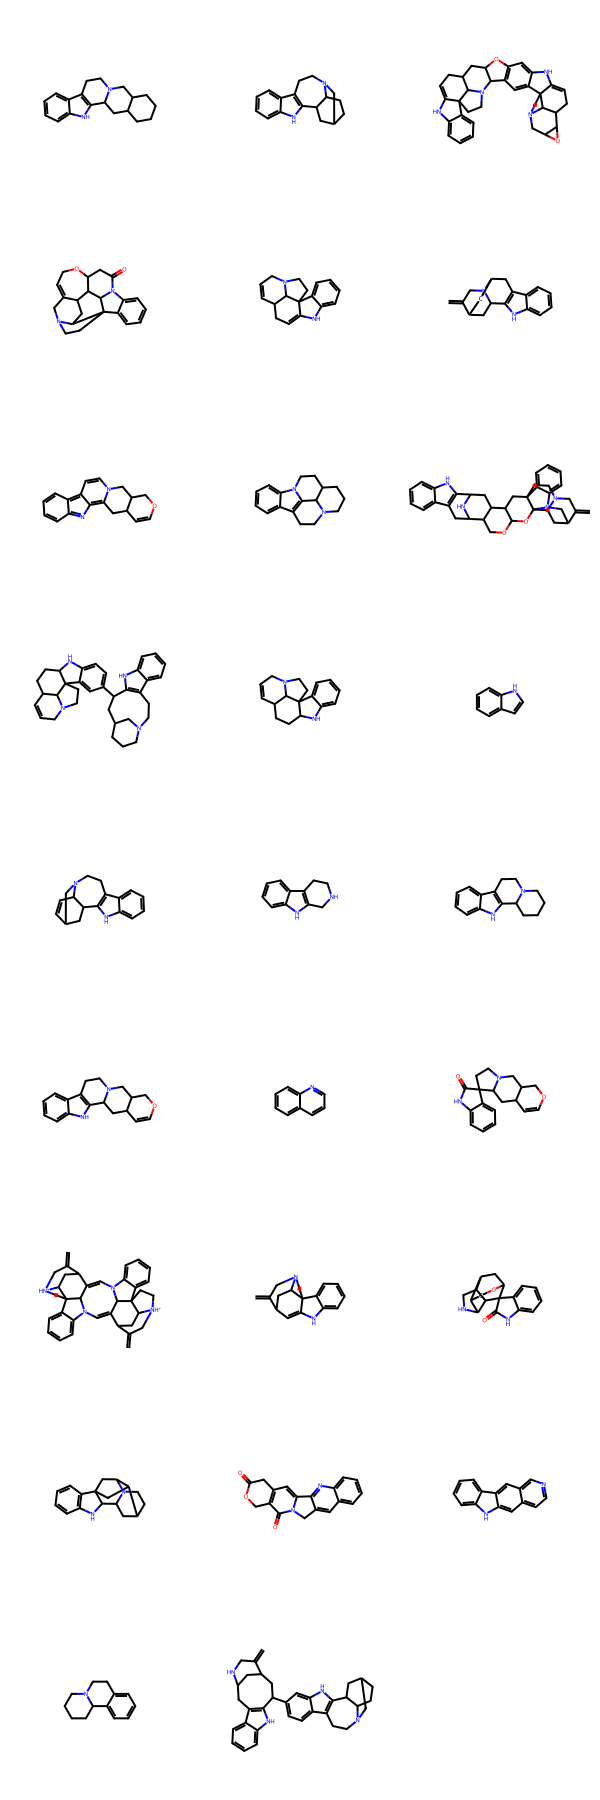

In [49]:
scaffolds = set()
for f in frags:
    idx = get_largest(f)
    largest = f[idx]
    sc = MurckoScaffold.GetScaffoldForMol(largest)
    Chem.RemoveStereochemistry(sc)
    smiles = Chem.MolToSmiles(sc, canonical=True)
    if smiles not in scaffolds:
        scaffolds.add(smiles)

Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in scaffolds])

In [ ]:
struct_with_scaffold = []
struct_no_scaffold = []
for mol in filtered:
    if any(mol.HasSubstructMatch(s) for s in [Chem.MolFromSmiles(x) for x in scaffolds]):
        struct_with_scaffold.append(mol)
    else:
        struct_no_scaffold.append(mol)

print(len(struct_with_scaffold), len(struct_no_scaffold))

1363 422
